### Alice combo notebook

In [2]:
import pickle
import numpy as np
import pandas as pd
from scipy.sparse import csr_matrix, hstack
from sklearn.preprocessing import StandardScaler
from sklearn.metrics import roc_auc_score
from sklearn.linear_model import LogisticRegression
from matplotlib import pyplot as plt
import seaborn as sns
sns.set()

In [4]:
# Read the training and test data sets, change paths if needed
times = ['time%s' % i for i in range(1, 11)]
train_df = pd.read_csv('../data/train_sessions.csv',
                       index_col='session_id', parse_dates=times)
test_df = pd.read_csv('../data/test_sessions.csv',
                      index_col='session_id', parse_dates=times)

# Sort the data by time
train_df = train_df.sort_values(by='time1')

# Look at the first rows of the training set
train_df.head()

,site1,time1,site2,time2,site3,time3,site4,time4,site5,time5,...,time6,site7,time7,site8,time8,site9,time9,site10,time10,target
session_id,,,,,,,,,,,,,,,,,,,,,
21669,56,2013-01-12 08:05:57,55.0,2013-01-12 08:05:57,NaN,NaT,NaN,NaT,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
54843,56,2013-01-12 08:37:23,55.0,2013-01-12 08:37:23,56.0,2013-01-12 09:07:07,55.0,2013-01-12 09:07:09,NaN,NaT,...,NaT,NaN,NaT,NaN,NaT,NaN,NaT,NaN,NaT,0
77292,946,2013-01-12 08:50:13,946.0,2013-01-12 08:50:14,951.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:15,946.0,2013-01-12 08:50:16,...,2013-01-12 08:50:16,948.0,2013-01-12 08:50:16,784.0,2013-01-12 08:50:16,949.0,2013-01-12 08:50:17,946.0,2013-01-12 08:50:17,0
114021,945,2013-01-12 08:50:17,948.0,2013-01-12 08:50:17,949.0,2013-01-12 08:50:18,948.0,2013-01-12 08:50:18,945.0,2013-01-12 08:50:18,...,2013-01-12 08:50:18,947.0,2013-01-12 08:50:19,945.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:19,946.0,2013-01-12 08:50:20,0
146670,947,2013-01-12 08:50:20,950.0,2013-01-12 08:50:20,948.0,2013-01-12 08:50:20,947.0,2013-01-12 08:50:21,950.0,2013-01-12 08:50:21,...,2013-01-12 08:50:21,946.0,2013-01-12 08:50:21,951.0,2013-01-12 08:50:22,946.0,2013-01-12 08:50:22,947.0,2013-01-12 08:50:22,0


In [5]:
# Change site1, ..., site10 columns type to integer and fill NA-values with zeros
sites = ['site%s' % i for i in range(1, 11)]
train_df[sites] = train_df[sites].fillna(0).astype(np.uint16)
test_df[sites] = test_df[sites].fillna(0).astype(np.uint16)

# Load websites dictionary
with open(r"../data/site_dic.pkl", "rb") as input_file:
    site_dict = pickle.load(input_file)

# Create dataframe for the dictionary
sites_dict = pd.DataFrame(list(site_dict.keys()), index=list(site_dict.values()), 
                          columns=['site'])
print(u'Websites total:', sites_dict.shape[0])
sites_dict.head()

Websites total: 48371


,site
25075,www.abmecatronique.com
13997,groups.live.com
42436,majeureliguefootball.wordpress.com
30911,cdt46.media.tourinsoft.eu
8104,www.hdwallpapers.eu


In [6]:
top_sites = pd.Series(train_df[sites].values.flatten()
                     ).value_counts().sort_values(ascending=False).head(25)
print(top_sites)
sites_dict.loc[top_sites.drop(0).index]

21     123776
0      122730
23      87619
782     77055
22      58258
29      54094
167     46405
780     43841
778     38194
52      36085
812     35178
80      31391
570     30616
55      27812
39      25275
37      23726
30      23495
786     23026
35      22470
76      20922
33      19683
3       18130
77      17270
616     16890
733     15920
dtype: int64


,site
21,www.google.fr
23,www.google.com
782,annotathon.org
22,apis.google.com
29,www.facebook.com
167,www.bing.com
780,blast.ncbi.nlm.nih.gov
778,www.ncbi.nlm.nih.gov
52,clients1.google.com
812,mail.google.com


In [7]:
# Our target variable
y_train = train_df['target']

# United dataframe of the initial data 
full_df = pd.concat([train_df.drop('target', axis=1), test_df])

# Index to split the training and test data sets
idx_split = train_df.shape[0]

In [8]:
full_sites = full_df[sites]
full_sites.head()

,site1,site2,site3,site4,site5,site6,site7,site8,site9,site10
session_id,,,,,,,,,,
21669,56,55,0,0,0,0,0,0,0,0
54843,56,55,56,55,0,0,0,0,0,0
77292,946,946,951,946,946,945,948,784,949,946
114021,945,948,949,948,945,946,947,945,946,946
146670,947,950,948,947,950,952,946,951,946,947


In [9]:
# sequence of indices
sites_flatten = full_sites.values.flatten()

# and the matrix we are looking for 
# (make sure you understand which of the `csr_matrix` constructors is used here)
# a further toy example will help you with it
full_sites_sparse = csr_matrix(([1] * sites_flatten.shape[0],
                                sites_flatten,
                                range(0, sites_flatten.shape[0]  + 10, 10)))[:, 1:]

In [10]:
def get_auc_lr_valid(X, y, C=1.0, seed=17, ratio = 0.9):
    # Split the data into the training and validation sets
    idx = int(round(X.shape[0] * ratio))
    # Classifier training
    lr = LogisticRegression(C=C, random_state=seed, solver='liblinear').fit(X[:idx, :], y[:idx])
    # Prediction for validation set
    y_pred = lr.predict_proba(X[idx:, :])[:, 1]
    # Calculate the quality
    score = roc_auc_score(y[idx:], y_pred)
    
    return score

In [11]:
%%time
# Select the training set from the united dataframe (where we have the answers)
X_train = full_sites_sparse[:idx_split, :]

# Calculate metric on the validation set
print(get_auc_lr_valid(X_train, y_train))

0.9195244077552184
CPU times: user 4.32 s, sys: 160 ms, total: 4.48 s
Wall time: 4.5 s


In [12]:
# Function for writing predictions to a file
def write_to_submission_file(predicted_labels, out_file,
                             target='target', index_label="session_id"):
    predicted_df = pd.DataFrame(predicted_labels,
                                index = np.arange(1, predicted_labels.shape[0] + 1),
                                columns=[target])
    predicted_df.to_csv(out_file, index_label=index_label)

In [13]:
times = ['time%s' % i for i in range(1, 11)]
full_df[times].describe()

,time1,time2,time3,time4,time5,time6,time7,time8,time9,time10
count,336358,331406,326994,323503,320170,317061,314137,311375,308568,305858
unique,313976,309442,305547,302155,298925,296163,293715,291220,288582,286002
top,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54,2014-05-27 11:36:54
freq,7,7,8,9,7,7,7,7,7,7
first,2013-01-12 08:05:57,2013-01-12 08:05:57,2013-01-12 08:50:15,2013-01-12 08:50:15,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:16,2013-01-12 08:50:17,2013-01-12 08:50:17
last,2014-12-05 23:26:53,2014-12-05 23:26:53,2014-12-05 23:56:23,2014-12-05 23:56:23,2014-12-05 20:24:08,2014-12-05 19:10:09,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03,2014-12-05 19:10:03


### FREERIDE

In [77]:
def get_last_time(rows):
    res = pd.to_datetime('2014-02-20 10:02:45')
    for x in rows:
        if (not pd.isnull(x)):
            res = x
        else:
            return res
    return res

def  get_time_diff (row): 
    time_length = row.shape[0] - 1 
    time_diff = [0]*time_length 
    i = 0 
    while (i < time_length)and pd.notnull(row[i+1]): 
        time_diff[i] = (row[i+1] - row[i]) /np.timedelta64(1,'s') 
        i += 1 
    return  time_diff

def get_total_time(row): 
    time_length = row.shape[0] - 1 
    i = time_length 
    while pd.isnull( row [ i ]): 
        i -= 1 
    return (row[i] - row[0]) / np.timedelta64(1,'s')

def get_last_site(row):
    for x in row:
        if (x != 0):
            res = x
        else:
            return res
    return res

def apply_is_yb(row):
    last = get_last_site(row)
    return is_site(last, youtube_ids)

def apply_is_fb(row):
    last = get_last_site(row)
    return is_site(last, facebook_ids)

def is_site(x, l):
    if x in l:
      return 1 
    return 0

def is_long_session(x):
    if x < 3:
        return 0
    elif x < 5:
        return 1
    elif x < 10:
        return 2
    elif x < 30:
        return 3
    elif x < 40:
        return 4
    return 5

In [40]:
# Dataframe for new features
full_add_df = pd.DataFrame(index=full_df.index)

# Add start_month feature
full_add_df['start_month'] = full_df['time1'].apply(lambda ts: 
                                                      100 * ts.year + ts.month)
full_add_df['start_hour'] = full_df['time1'].apply(lambda ts: ts.hour)
full_add_df['start_day'] = full_df['time1'].apply(pd.datetime.weekday)
full_add_df['stop_hour'] = full_df[times].apply(get_last_time, axis=1).apply(lambda x: x.hour)
full_add_df['stop_month'] = full_df[times].apply(get_last_time, axis=1).apply(lambda x: x.month)
full_add_df['stop_day'] = full_df[times].apply(get_last_time, axis=1).apply(pd.datetime.weekday)

In [41]:
full_add_df['morning'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour <= 11) & (ts.hour >= 7)) else 0).astype('int')
full_add_df['day'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 12) & (ts.hour <= 18)) else 0).astype('int')
full_add_df['evening'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 19) & (ts.hour <= 23)) else 0).astype('int')
full_add_df['night'] = full_df['time1'].apply(lambda ts: 1 if ((ts.hour >= 0) & (ts.hour <= 6)) else 0).astype('int')

In [42]:
## Add time diff
full_time = full_df[times]
time_diff = []
for row in full_time.values:
    time_diff.append (get_time_diff (row))
time_diff = np.log1p(np.array(time_diff).astype(float))

time_names = ['time_diff'+str(j) for j in range(1,10)] 
for ind,column_name in enumerate(time_names): 
    full_add_df[column_name] = time_diff[:,ind] 
    
full_add_df.head()

,start_month,start_hour,start_day,stop_hour,stop_month,stop_day,morning,day,evening,night,time_diff1,time_diff2,time_diff3,time_diff4,time_diff5,time_diff6,time_diff7,time_diff8,time_diff9
session_id,,,,,,,,,,,,,,,,,,,
21669,201301,8,5,8,1,5,1,0,0,0,0.000000,0.000000,0.000000,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
54843,201301,8,5,9,1,5,1,0,0,0,0.000000,7.487174,1.098612,0.000000,0.0,0.000000,0.000000,0.000000,0.000000
77292,201301,8,5,8,1,5,1,0,0,0,0.693147,0.693147,0.000000,0.693147,0.0,0.000000,0.000000,0.693147,0.000000
114021,201301,8,5,8,1,5,1,0,0,0,0.000000,0.693147,0.000000,0.000000,0.0,0.693147,0.000000,0.000000,0.693147
146670,201301,8,5,8,1,5,1,0,0,0,0.000000,0.000000,0.693147,0.000000,0.0,0.000000,0.693147,0.000000,0.000000


In [73]:
# years and months
full_add_df['yyyymm'] = full_df['time1'].apply(lambda ts: 100 * ts.year + ts.month).astype(np.int32) 
full_add_df['mm'] = full_df['time1'].apply(lambda ts: ts.month).astype(np.int8)
full_add_df['yyyy'] = full_df['time1'].apply(lambda ts: ts.year).astype(np.int8)

In [74]:
# minuties feature
full_df['min'] = full_df[times].min(axis=1)
full_df['max'] = full_df[times].max(axis=1)
full_add_df['minutes'] = ((full_df['max'] - full_df['min']) / np.timedelta64(1, 'm')).round(2)
full_df.drop(['min','max'], inplace=True, axis=1)

In [75]:
hosts = pd.read_pickle('../data/site_dic.pkl')
hosts = pd.DataFrame(data=list(hosts.keys()), index=list(hosts.values()), columns=['name']) # switch key and value

hosts['split'] = hosts['name'].str.split('.')
hosts['len'] = hosts['split'].map(lambda x: len(x)).astype(np.int8)
hosts['domain'] = hosts['split'].map(lambda x: x[-1])

hosts.drop(['name','split'], inplace=True, axis=1)
hosts.index.rename('site1', inplace=True) # rename index for the future merge
full_df = pd.merge(full_df, hosts, how='left', on='site1')

full_add_df['big_site'] = full_df['len'].apply(lambda x: x > 5).astype(np.int8)
full_add_df['typical_site'] = full_df['len'].apply(lambda x: x == 3).astype(np.int8)
full_add_df['typical_domain'] = full_df['domain'].map(lambda x: x in ('com', 'fr', 'net', 'uk', 'org', 'tv')).astype(np.int)

In [78]:
full_add_df['duration'] = (full_df[times].apply(get_last_time, axis=1) - full_df['time1']).astype(int).apply(lambda x: x/10e8)
full_add_df['duration'] = full_add_df['duration'].apply(is_long_session).astype('int')

In [80]:
facebook_ids = []
youtube_ids = []
# Load websites dictionary
with open(r"../data/site_dic.pkl", "rb") as input_file:
    site_dict_new = pickle.load(input_file)
    
for key in list(site_dict_new.keys()):
    if 'facebook' in key:
        facebook_ids.append(site_dict_new[key])
    if 'youtube' in key:
        youtube_ids.append(site_dict_new[key])
print(youtube_ids)

[38132, 41285, 80, 38133, 15317, 656, 16672, 874, 6581, 38134, 24557, 1307, 12597, 76, 14774, 1345, 74, 16606, 28062, 2329, 1056, 676, 2574, 13347]


In [81]:
full_add_df['yb start'] = full_df['site1'].apply(lambda x: is_site(x, youtube_ids))
full_add_df['fb start'] = full_df['site1'].apply(lambda x: is_site(x, facebook_ids))
full_add_df['yb end'] = full_df[sites].apply(apply_is_yb, axis = 1)
full_add_df['fb end'] = full_df[sites].apply(apply_is_fb, axis = 1)

In [84]:
site_dict  =  {} 
for  row  in  full_sites.values : 
    for  site_id  in  np.unique ( row ): 
        if  site_id  in  site_dict : 
            site_dict [ site_id ]  +=  1 
        else : 
            site_dict [ site_id ]  =  1 
site_dict.pop(0)

30500

In [85]:
absolutely_unique_count  =  np.zeros((full_sites.shape[0], 1 ), dtype = int ) 
ind  =  0 
for  row  in  full_sites.values: 
    unique  =  np.unique ( row ) 
    absolutely_unic_row  =  {} 
    for site_id in unique: 
        if (site_id !=0) and (site_dict[site_id] == 1) and (site_id not in absolutely_unic_row): 
            absolutely_unique_count [ind]  +=  1 
            absolutely_unic_row [site_id]  =  1 
    ind  +=  1
full_add_df['absolutely_unique_count'] = absolutely_unique_count
absolutely_unique = (absolutely_unique_count > 0 ).astype(int)
full_add_df ['have_absolutely_unique'] = absolutely_unique

In [178]:
full_add_df['holiday']     = (full_df['time1'].dt.dayofweek >= 5).astype(int) 
full_add_df['day_of_week'] = (full_df['time1'].dt.dayofweek).astype(int)

In [192]:
total_time = []
for row in full_time.values:
    total_time.append(get_total_time(row))
total_time = np.array(total_time).reshape(-1,1).astype(int)

full_add_df['total_time'] =  total_time 
full_add_df['total_time'] =  np.log1p(full_add_df['total_time'].values)

### Visualisation

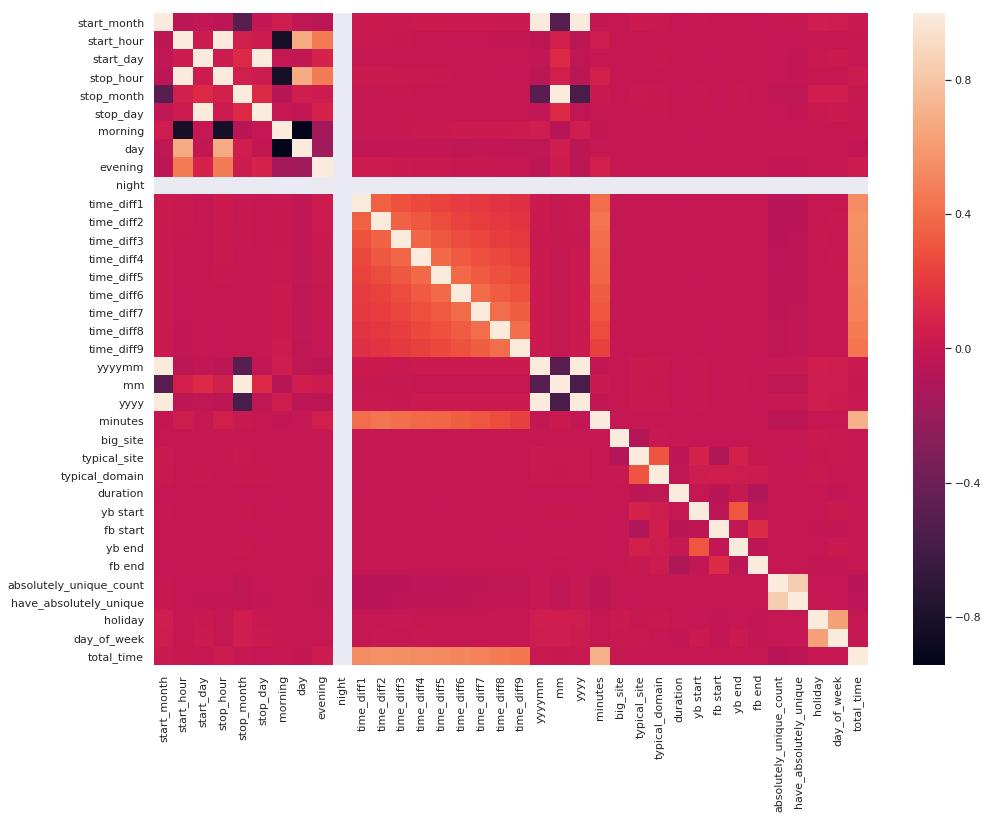

In [193]:
plt.figure(figsize = (16,12))

sns.heatmap(full_add_df.corr())

### Train model

In [216]:
dummies_cols = ['morning',
               'evening',
               'day',
               'night',
               'start_hour',
               'start_day',
               'start_month',
                'stop_month',

                'duration',
               'yyyymm',
#                 'big_site',
                'day_of_week',
                'holiday',
                'typical_site',
                'fb start',
                'fb end',
                'yb start',
                'yb end'
               ]
scaled_cols = [
               'start_hour',
               'start_day',
               'start_month',
               'stop_month',
#                'time_diff1',
#                'time_diff2',
#                'time_diff3',
#                'time_diff4',
#                'time_diff5',
#                'time_diff6',
#                'time_diff7',
#                'time_diff8',
#                'time_diff9',
               'minutes',
               'absolutely_unique_count'
              ]

In [217]:
full_add_df_dummies  = pd.get_dummies(full_add_df , columns=dummies_cols) 

In [218]:
tmp_scaled = StandardScaler().fit_transform(full_add_df[scaled_cols])

X_train = csr_matrix(hstack([full_sites_sparse[:idx_split,:], 
                                 tmp_scaled[:idx_split,:],
                                full_add_df_dummies[:idx_split],
#                                 full_add_df_nonscalable[:idx_split]
                                ]))
X_test = csr_matrix(hstack([full_sites_sparse[idx_split:,:], 
                                tmp_scaled[idx_split:,:],
                               full_add_df_dummies[idx_split:],
#                                 full_add_df_nonscalable[idx_split:]
                               ]))

/opt/conda/lib/python3.6/site-packages/sklearn/preprocessing/data.py:625: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.partial_fit(X, y)
/opt/conda/lib/python3.6/site-packages/sklearn/base.py:462: DataConversionWarning: Data with input dtype int64, float64 were all converted to float64 by StandardScaler.
  return self.fit(X, **fit_params).transform(X)


In [219]:
get_auc_lr_valid(X_train, y_train) #0.9858117581844268

0.9857492609016999

In [220]:
from sklearn.model_selection import TimeSeriesSplit, cross_val_score, GridSearchCV


time_split = TimeSeriesSplit(n_splits=10)
[(el[0].shape, el[1].shape) for el in time_split.split(X_train)]
logit = LogisticRegression(C=1.0, random_state=17, solver='liblinear')
cv_scores = cross_val_score(logit, X_train, y_train, cv=time_split, 
                            scoring='roc_auc', n_jobs=1)

In [221]:
cv_scores.mean() #0.9172733566381384

0.9155306725988582

In [222]:
c_values = np.logspace(-2, 2, 10)

logit_grid_searcher = GridSearchCV(estimator=logit, param_grid={'C': c_values},
                                  scoring='roc_auc', n_jobs=1, cv=time_split, verbose=1)
logit_grid_searcher.fit(X_train, y_train)

Fitting 10 folds for each of 10 candidates, totalling 100 fits


[Parallel(n_jobs=1)]: Using backend SequentialBackend with 1 concurrent workers.
/opt/conda/lib/python3.6/site-packages/sklearn/svm/base.py:931: ConvergenceWarning: Liblinear failed to converge, increase the number of iterations.
  "the number of iterations.", ConvergenceWarning)
[Parallel(n_jobs=1)]: Done 100 out of 100 | elapsed: 20.6min finished


GridSearchCV(cv=TimeSeriesSplit(max_train_size=None, n_splits=10),
       error_score='raise-deprecating',
       estimator=LogisticRegression(C=1.0, class_weight=None, dual=False, fit_intercept=True,
          intercept_scaling=1, max_iter=100, multi_class='warn',
          n_jobs=None, penalty='l2', random_state=17, solver='liblinear',
          tol=0.0001, verbose=0, warm_start=False),
       fit_params=None, iid='warn', n_jobs=1,
       param_grid={'C': array([1.00000e-02, 2.78256e-02, 7.74264e-02, 2.15443e-01, 5.99484e-01,
       1.66810e+00, 4.64159e+00, 1.29155e+01, 3.59381e+01, 1.00000e+02])},
       pre_dispatch='2*n_jobs', refit=True, return_train_score='warn',
       scoring='roc_auc', verbose=1)

In [223]:
logit_grid_searcher.best_score_, logit_grid_searcher.best_params_

(0.9158708429685878, {'C': 0.21544346900318834})

In [225]:
logit_test_pred3 = logit_grid_searcher.predict_proba(X_test)[:, 1]
write_to_submission_file(logit_test_pred3, 'subm11.csv') # 

In [ ]:
#0.952